## Sentence Modality Notebook

### Imported libraries

In [97]:
import os
import urllib.request
import zipfile
import xml.etree.ElementTree as ET

%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle

import tensorflow as tf
from keras.preprocessing.text import text_to_word_sequence
from keras.layers import Embedding,LSTM,Dense
from keras.callbacks import TensorBoard,ModelCheckpoint,Callback
from keras import backend as K

In [2]:
dl_PATH = './downloads/'

### Functions for downloading and unzipping modality data
All data is saved to the downloads file so as to not be uploaded to github.

In [3]:
def maybe_download(url, name):
    
    global dl_PATH
    
    if not os.path.exists(dl_PATH):
        os.makedirs(dl_PATH)
        
    if os.path.isfile(dl_PATH+name):
        print(name+' already downloaded.')
    else:
        try:
            urllib.request.urlretrieve(url, dl_PATH+name)
            print(name+' successfully downloaded.')
        except:
            print('Error downloading '+name+'.')
        
def maybe_unzip(zname):
    global dl_PATH
    
    if not os.path.isfile(dl_PATH+'task1_train_bio_abstracts_rev2.xml'):
        with zipfile.ZipFile(dl_PATH+zname, 'r') as zipref:
            zipref.extractall(dl_PATH)
    else:
        print(zname+' already unzipped.')

In [4]:
maybe_download('http://rgai.inf.u-szeged.hu/~vinczev/conll2010st/task1_train_bio_rev2.zip', 'task1_train_bio.zip')
maybe_unzip('task1_train_bio.zip') #'task1_train_bio_abstracts_rev2.xml' and 'task1_train_bio_fullarticles_rev2.xml'

task1_train_bio.zip already downloaded.
task1_train_bio.zip already unzipped.


### Class/functions definitions for handling .xml data files
The data is presented in an xml file format and is processed here into an ElementTree. The element tree behaves similarly to a nested list structure with a few extra methods.


In [45]:
class TextData(object):
    def __init__(self, xml):
        with open(dl_PATH+xml) as fd:
            self.ETree = ET.parse(fd)
            
    def totaldocNo(self):
        return(len(self.get_documents()))
        
    def totsentNo(self):
        N = 0
        for doc in self.getdocuments():
            N += len(doc[2][:])
        return(N)
    
    def get_docs(self, start=None, stop=None):
        return(self.ETree.getroot()[0][start:stop])
    
    def tosent(doc):
        return(doc[2][:])
    
    def get_sentences(self):
        sentences = []
        for doc in self.get_docs():
            for part in doc[1:]:
                for sent in part[:]:
                    sentences.append(sent)
        return(sentences)

def toString(sentElement):
    sent = sentElement.text
    if sent == None:
        sent = ''
    ccuelen = len(sentElement.getchildren())
    if ccuelen > 0:
        for i in range(ccuelen):
            sent += sentElement[i].text
            sent += sentElement[i].tail
    return(sent)

def toStrings(sentElements):
    strings = []
    for element in sentElements:
        strings.append(toString(element))
    return(strings)
    
def isCertain(sentElement):
    if sentElement.attrib['certainty'] == 'certain':
        return(True)
    else:
        return(False)
    
def get_cues(sentElement):
    return sentElement.getchildren()

def num_words(string):
    return len(text_to_word_sequence(string,
                                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                     lower=True,
                                     split=" "))

def cue_positions(sentElement):
    pos = 0
    positions = []
    pos += num_words(toString(sentElement))
    for cue in get_cues(sentElement)[::-1]:
        pos -= num_words(cue.tail)
        pos -= num_words(cue.text)
        positions.append(pos)
    return(positions[::-1])


In [42]:
data = TextData('task1_train_bio_abstracts_rev2.xml')    

In [7]:
print(data.get_docs(0,1)[0])


<Element 'Document' at 0x11dc027c8>


In [70]:
sentences = data.get_sentences()
sentence_lengths = []
for sentence in toStrings(sentences):
    sentence_lengths.append(num_words(sentence))

145


<IPython.core.display.Javascript object>


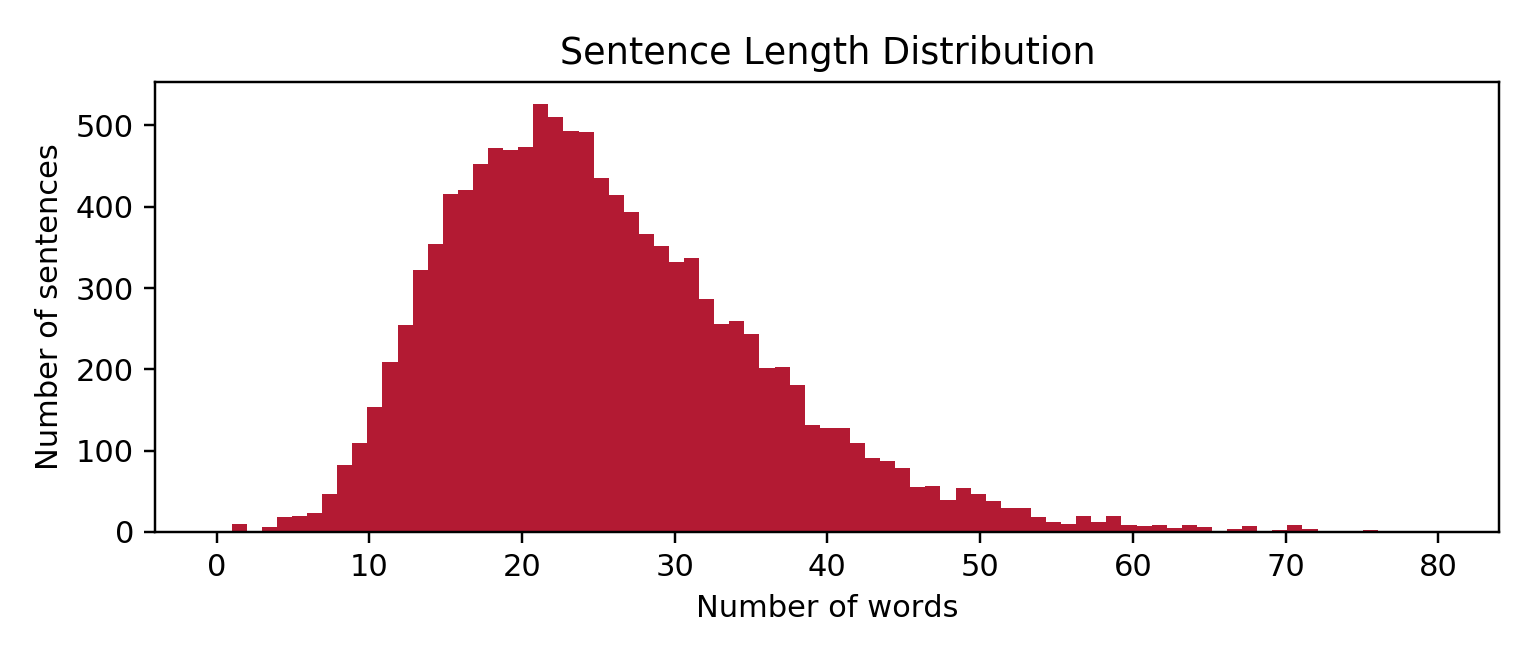

In [48]:
fig1 = plt.figure(figsize=(7,3))
ax1 = fig1.gca()
ax1.set_title('Sentence Length Distribution')
ax1.set_ylabel('Number of sentences')
ax1.set_xlabel('Number of words')
plt.hist(sentence_lengths,bins=81,range=(0,80),color=[0.7,0.1,0.2])
plt.tight_layout()
plt.show()

In [123]:
def generate_batches(sentences, maxlen, batchsize):
    # Creates a list of input data for training the RNN. 
    # Each batch contains sentences with lengths binned into mulitples of 10.

    max_size = int((maxlen+9)/10)
    size_grouped = []
    for i in range(max_size):
        size_grouped.append([])
    for sentence in sentences:
        string = toString(sentence)
        words = text_to_word_sequence(string,
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                          lower=True,
                          split=" ")
        size = int((len(words)+9)/10)
        if size <= max_size:
            certainty = [isCertain(sentence)]
            size_grouped[size-1].append([words,certainty])

    batches = []
    
    sizehistx = []
    sizehisty = []
    l = 10
    for group in size_grouped:
        sizehistx.append(str(l))
        l+=10
        shuffle(group)
        numbatch = int(len(group)/batchsize)+1
        sizehisty.append(numbatch)
        group.append(group[:len(group)%batchsize+1])
        for i in range(numbatch):
            batches.append(group[(i)*batchsize:(i+1)*batchsize])
    fig2 = plt.figure(figsize=(7,3))
    ax2 = fig2.gca()
    ax2.set_title('Number of Batches per Sentence Length')
    ax2.set_ylabel('Number of batches')
    ax2.set_xlabel('Number of words')
    plt.bar(sizehistx,sizehisty,color=[0.7,0.1,0.2])
    plt.tight_layout()
    plt.show()
    return(shuffle(batches))        

<IPython.core.display.Javascript object>


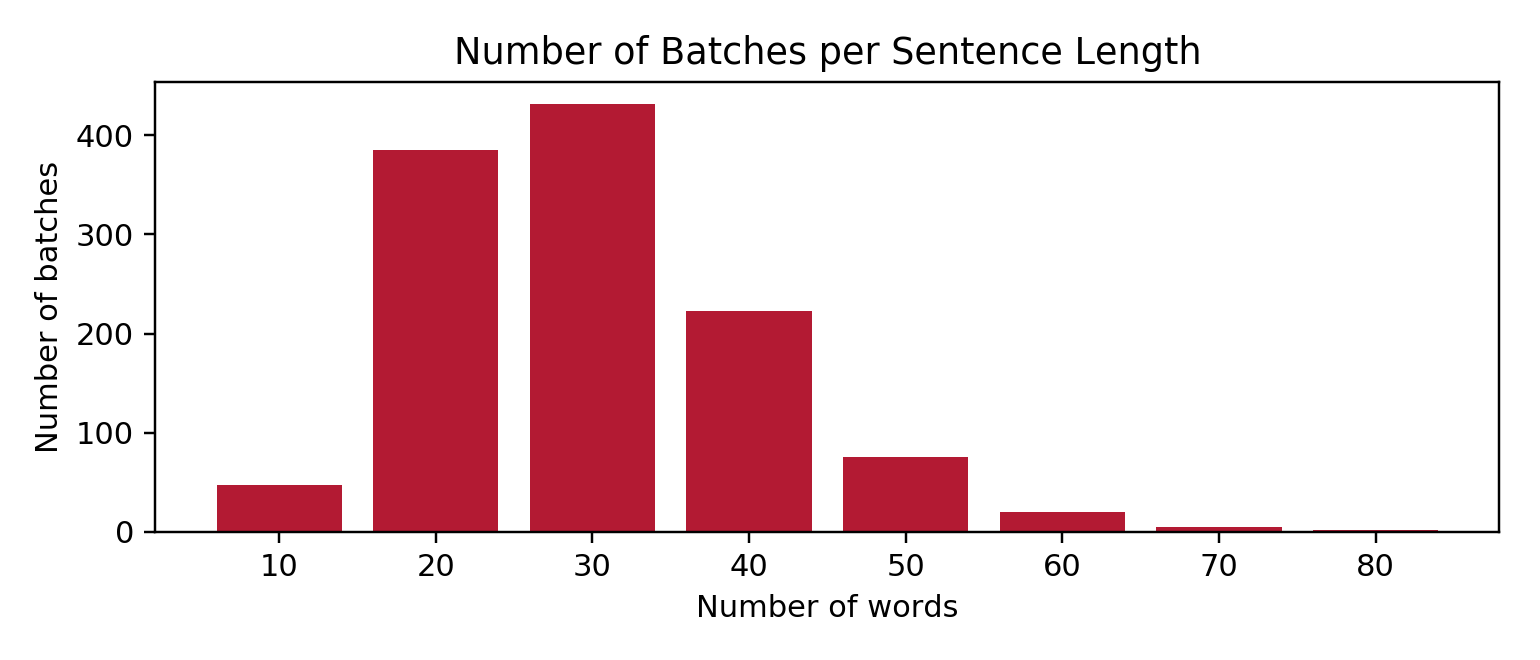

In [124]:
generate_batches(sentences,80,10)